In [1]:
# 3.0 - Entrenamiento del Modelo de Triaje (SVM Optimizado)
# ==============================================================================
# Este notebook se encarga de:
# 1. Cargar los datos procesados.
# 2. Refinar las etiquetas (Fusionar clases confusas para mejorar precisión).
# 3. Entrenar el modelo SVM con la mejor configuración encontrada (Bigramas + C=100).
# 4. Evaluar y guardar el modelo final ("pipeline") para producción.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuración de Rutas
INPUT_FILE = '../data/processed/datos_nlp_procesados.csv'
MODELS_PATH = '../models/'

print("✅ Librerías cargadas.")

✅ Librerías cargadas.


In [2]:
# Cargar datos
try:
    df = pd.read_csv(INPUT_FILE)
    print(f"📄 Datos cargados: {len(df)} registros.")
except FileNotFoundError:
    print("❌ No se encuentra el archivo procesado. Ejecuta el notebook 2.0 primero.")

# Ver distribución original
print("\n--- Distribución Original ---")
print(df['especialidad'].value_counts())

📄 Datos cargados: 22086 registros.

--- Distribución Original ---
especialidad
TRAUMATOLOGÍA/MUSCULAR                2393
UROLOGÍA/RENAL                        2071
OFTALMOLOGÍA/ORL                      2026
CARDIOLOGÍA/CIRCULATORIO              1682
GASTROENTEROLOGÍA/DIGESTIVO           1545
NEUROLOGÍA                            1270
MEDICINA GENERAL                      1097
ONCOLOGÍA (TUMORES)                   1054
PSIQUIATRÍA/MENTAL                    1010
ENDOCRINOLOGÍA/NUTRICIÓN               969
SANGRE/INMUNOLOGÍA                     964
DERMATOLOGÍA                           947
INFECCIOSAS/PARASITARIAS               943
URGENCIAS/TRAUMA                       936
RESPIRATORIO/NEUMOLOGÍA                928
ODONTOLOGÍA                            923
PEDIATRÍA                              911
SÍNTOMAS GENERALES/NO CLASIFICADOS     259
GINECOLOGÍA/OBSTETRICIA                158
Name: count, dtype: int64


In [3]:
print("🔧 Aplicando corrección y fusión de etiquetas...")

def unificar_categorias(especialidad):
    especialidad = str(especialidad).upper().strip()
    
    # 1. Fusión de Traumatología
    # Unimos "TRAUMATOLOGÍA", "TRAUMATOLOGÍA/LESIONES", "TRAUMATOLOGÍA/MUSCULAR"
    if 'TRAUMATOLOGÍA' in especialidad: 
        return 'TRAUMATOLOGÍA/MUSCULAR'
    
    # 2. Agrupar clases muy pequeñas (< 100 datos) para no confundir al modelo
    # Estas clases suelen tener precisión de 0.00 si no se agrupan
    
    clases_minoritarias = []
    
    if especialidad in clases_minoritarias:
        return 'MEDICINA GENERAL'
        
    return especialidad

# Aplicar la función
df['especialidad_final'] = df['especialidad'].apply(unificar_categorias)

# Ver cómo quedó
print("\n--- Distribución Final (Para Entrenar) ---")
conteo = df['especialidad_final'].value_counts()
print(conteo)

# Filtrar si hay alguna clase que quedó con poquísimos datos (ej: < 20)
# df = df[df['especialidad_final'] != 'CLASE_A_BORRAR']

🔧 Aplicando corrección y fusión de etiquetas...

--- Distribución Final (Para Entrenar) ---
especialidad_final
TRAUMATOLOGÍA/MUSCULAR                2393
UROLOGÍA/RENAL                        2071
OFTALMOLOGÍA/ORL                      2026
CARDIOLOGÍA/CIRCULATORIO              1682
GASTROENTEROLOGÍA/DIGESTIVO           1545
NEUROLOGÍA                            1270
MEDICINA GENERAL                      1097
ONCOLOGÍA (TUMORES)                   1054
PSIQUIATRÍA/MENTAL                    1010
ENDOCRINOLOGÍA/NUTRICIÓN               969
SANGRE/INMUNOLOGÍA                     964
DERMATOLOGÍA                           947
INFECCIOSAS/PARASITARIAS               943
URGENCIAS/TRAUMA                       936
RESPIRATORIO/NEUMOLOGÍA                928
ODONTOLOGÍA                            923
PEDIATRÍA                              911
SÍNTOMAS GENERALES/NO CLASIFICADOS     259
GINECOLOGÍA/OBSTETRICIA                158
Name: count, dtype: int64


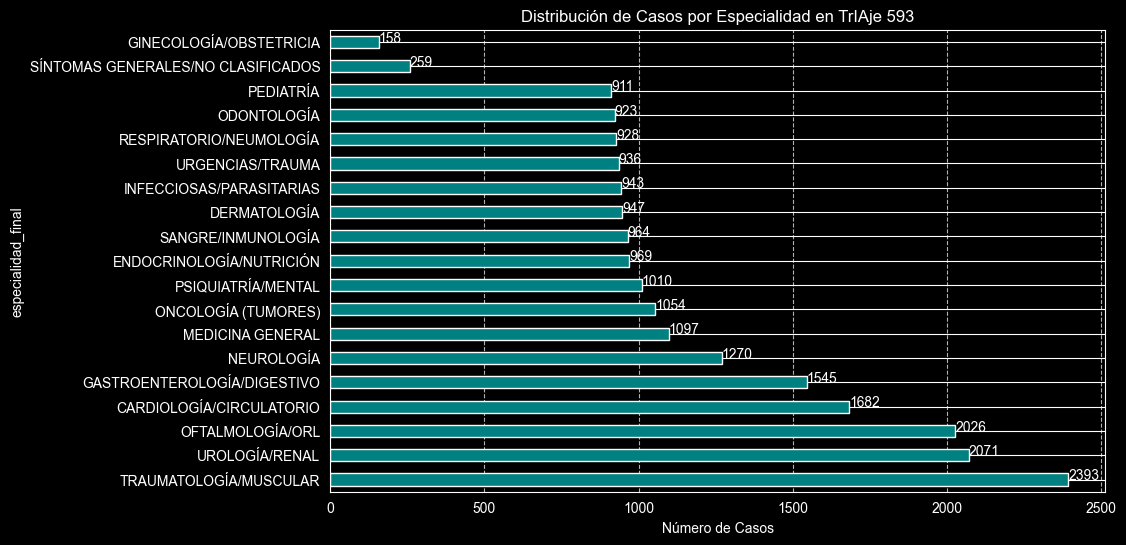

<Figure size 640x480 with 0 Axes>

In [4]:
# Ver cuántos casos se tiene por especialidad (Importante para saber si está balanceado)
plt.figure(figsize=(10,6))
conteo.plot(kind='barh', color='teal')
plt.title('Distribución de Casos por Especialidad en TrIAje 593')
plt.xlabel('Número de Casos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar los valores en el gráfico
conteo.values
for index, value in enumerate(conteo):
    plt.text(value, index, str(value))

plt.show()

# Guardar grafico
plt.savefig('../data/external/distribucion_especialidades_corregidas.png', bbox_inches='tight')

In [5]:
# 1. Separar características (X) y objetivo (y)
X = df['sintomas_procesados'].astype(str) # Asegurar que sea texto
y_nombres = df['especialidad_final']

# 2. Codificar las nuevas etiquetas a números
le_final = LabelEncoder()
y = le_final.fit_transform(y_nombres)

# Guardar este NUEVO LabelEncoder (Reemplaza al anterior)
with open(os.path.join(MODELS_PATH, 'label_encoder_final.pkl'), 'wb') as f:
    pickle.dump(le_final, f)
    print("💾 Nuevo LabelEncoder guardado.")

# 3. Split Estratificado (Mantiene la proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Entrenamiento: {len(X_train)} | Prueba: {len(X_test)}")

💾 Nuevo LabelEncoder guardado.
Entrenamiento: 17668 | Prueba: 4418


In [6]:
# Creamos un "Pipeline"
# Esto conecta el vectorizador directamente con el modelo.

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),    # Bigramas (Clave)
        min_df=2,              # Ignorar errores únicos
        max_features=None,     # Usar todo el vocabulario
        strip_accents='unicode',
        lowercase=True
    )),
    ('svm', SVC(
        C=100,                 # Margen estricto
        kernel='linear',       # Separación lineal
        class_weight='balanced', 
        probability=True       # Para ver % de confianza en la demo
    ))
])

print("🚀 Entrenando modelo SVM (Pipeline)...")
pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado.")

🚀 Entrenando modelo SVM (Pipeline)...
✅ Entrenamiento completado.



🏆 PRECISIÓN DEL MODELO: 94.57%

--- Reporte Detallado ---
                                    precision    recall  f1-score   support

          CARDIOLOGÍA/CIRCULATORIO       0.92      0.96      0.94       336
                      DERMATOLOGÍA       0.99      0.97      0.98       189
          ENDOCRINOLOGÍA/NUTRICIÓN       0.99      0.92      0.96       194
       GASTROENTEROLOGÍA/DIGESTIVO       0.94      0.90      0.92       309
           GINECOLOGÍA/OBSTETRICIA       0.86      0.75      0.80        32
          INFECCIOSAS/PARASITARIAS       0.99      0.97      0.98       189
                  MEDICINA GENERAL       0.83      0.95      0.89       219
                        NEUROLOGÍA       0.86      0.87      0.86       254
                       ODONTOLOGÍA       1.00      1.00      1.00       185
                  OFTALMOLOGÍA/ORL       0.98      0.97      0.98       405
               ONCOLOGÍA (TUMORES)       0.96      0.91      0.94       211
                         PED

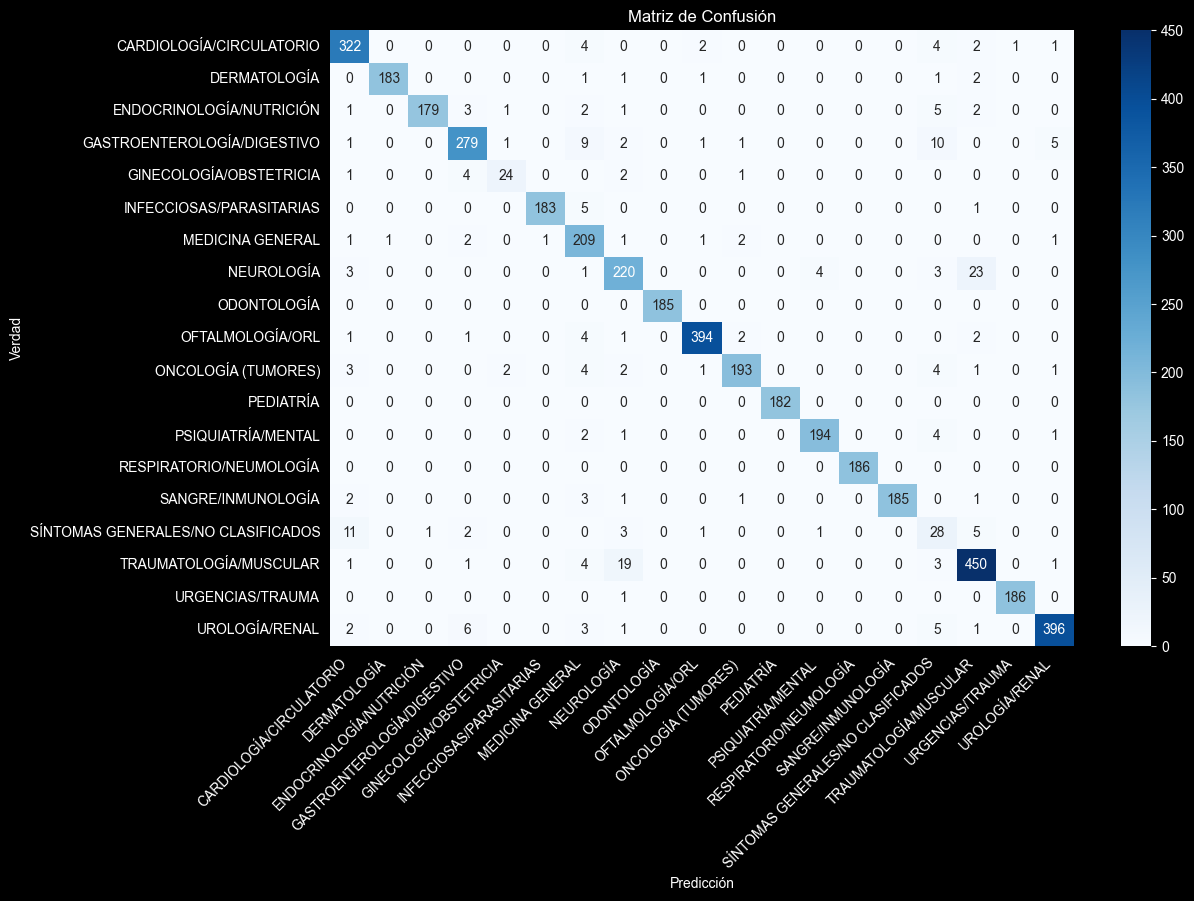

<Figure size 640x480 with 0 Axes>

In [7]:
# Predicciones
y_pred = pipeline.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
print(f"\n🏆 PRECISIÓN DEL MODELO: {acc*100:.2f}%")

print("\n--- Reporte Detallado ---")
print(classification_report(y_test, y_pred, target_names=le_final.classes_))

# Matriz de Confusión Visual
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_final.classes_, 
            yticklabels=le_final.classes_)
plt.title('Matriz de Confusión')
plt.ylabel('Verdad')
plt.xlabel('Predicción')
plt.xticks(rotation=45, ha='right')
plt.show()

# Guardar matriz de confusión
plt.savefig('../data/external/matriz_confusion_modelo_final.png')

In [8]:
# Guardamos el pipeline completo (TFIDF + SVM)
MODEL_FILE = os.path.join(MODELS_PATH, 'modelo_triaje_svm.pkl')

with open(MODEL_FILE, 'wb') as f:
    pickle.dump(pipeline, f)

print(f"💾 Modelo final guardado en: {MODEL_FILE}")
print("\n¡Proyecto listo para pasar a Producción (App/Web)!")

💾 Modelo final guardado en: ../models/modelo_triaje_svm.pkl

¡Proyecto listo para pasar a Producción (App/Web)!


In [9]:
# ==================
# 🏆 DEMO DE PRUEBA
# ==================

# Cargar el modelo guardado
with open('../models/modelo_triaje_svm.pkl', 'rb') as f:
    modelo_cargado = pickle.load(f)
# Cargar el label encoder guardado
with open('../models/label_encoder_final.pkl', 'rb') as f:
    label_encoder_cargado = pickle.load(f)

# Ejemplo de uso
def predecir_especialidad(sintomas):
    prediccion_num = modelo_cargado.predict([sintomas])[0]
    prediccion_texto = label_encoder_cargado.inverse_transform([prediccion_num])[0]
    return prediccion_texto
ejemplo_sintomas = ["Paciente con dolor torácico intenso, dificultad para respirar y sudoración profusa.",
                    "Fiebre alta, tos persistente y dolor de garganta desde hace tres días.",
                    "Dolor abdominal severo, náuseas y vómitos después de comer.",
                    "Mareos, visión borrosa y debilidad en las extremidades.",
                    "Erupción cutánea con picazón intensa y ampollas en varias partes del cuerpo.",
                    "Dolor de cabeza intenso, rigidez en el cuello y sensibilidad a la luz.",
                    "Dolor en las articulaciones, hinchazón y dificultad para moverse.",
                    "Dificultad para respirar, sibilancias y opresión en el pecho.",
                    "Dolor lumbar severo, entumecimiento en las piernas y pérdida de control de la vejiga.",
                    "Fatiga extrema, pérdida de peso inexplicada y sudores nocturnos.",
                    ]
for sintomas in ejemplo_sintomas:
    especialidad_predicha = predecir_especialidad(sintomas)
    print(f"Sintomas: {sintomas}\n➡️ Especialidad Predicha: {especialidad_predicha}\n")


Sintomas: Paciente con dolor torácico intenso, dificultad para respirar y sudoración profusa.
➡️ Especialidad Predicha: CARDIOLOGÍA/CIRCULATORIO

Sintomas: Fiebre alta, tos persistente y dolor de garganta desde hace tres días.
➡️ Especialidad Predicha: SÍNTOMAS GENERALES/NO CLASIFICADOS

Sintomas: Dolor abdominal severo, náuseas y vómitos después de comer.
➡️ Especialidad Predicha: MEDICINA GENERAL

Sintomas: Mareos, visión borrosa y debilidad en las extremidades.
➡️ Especialidad Predicha: NEUROLOGÍA

Sintomas: Erupción cutánea con picazón intensa y ampollas en varias partes del cuerpo.
➡️ Especialidad Predicha: DERMATOLOGÍA

Sintomas: Dolor de cabeza intenso, rigidez en el cuello y sensibilidad a la luz.
➡️ Especialidad Predicha: OFTALMOLOGÍA/ORL

Sintomas: Dolor en las articulaciones, hinchazón y dificultad para moverse.
➡️ Especialidad Predicha: NEUROLOGÍA

Sintomas: Dificultad para respirar, sibilancias y opresión en el pecho.
➡️ Especialidad Predicha: CARDIOLOGÍA/CIRCULATORIO

Sin